# Import libraries & data


In [110]:
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_curve,
    auc,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from pprint import pprint

import pandas as pd
import seaborn as sns
import numpy as np

In [91]:
train_master = pd.read_csv("data/train.csv")
train_master.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [92]:
features_names = list(train_master.columns[1:])

orginal_train = pd.read_csv("data/Faults.NNA", sep="\t", names=features_names)

print(orginal_train.shape)
orginal_train.head()

(1941, 34)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [93]:
train = train_master.copy().drop("id", axis=1)
train = pd.concat([train, orginal_train])

print(train.shape)
train.head()

(21160, 34)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


# Configuration


In [94]:
TARGET_FEATURES = [
    "Pastry",
    "Z_Scratch",
    "K_Scatch",
    "Stains",
    "Dirtiness",
    "Bumps",
    "Other_Faults",
]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# EDA


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21160 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21160 non-null  int64  
 1   X_Maximum              21160 non-null  int64  
 2   Y_Minimum              21160 non-null  int64  
 3   Y_Maximum              21160 non-null  int64  
 4   Pixels_Areas           21160 non-null  int64  
 5   X_Perimeter            21160 non-null  int64  
 6   Y_Perimeter            21160 non-null  int64  
 7   Sum_of_Luminosity      21160 non-null  int64  
 8   Minimum_of_Luminosity  21160 non-null  int64  
 9   Maximum_of_Luminosity  21160 non-null  int64  
 10  Length_of_Conveyer     21160 non-null  int64  
 11  TypeOfSteel_A300       21160 non-null  int64  
 12  TypeOfSteel_A400       21160 non-null  int64  
 13  Steel_Plate_Thickness  21160 non-null  int64  
 14  Edges_Index            21160 non-null  float64
 15  Emp

In [41]:
train.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

## Nulls & Duplicates


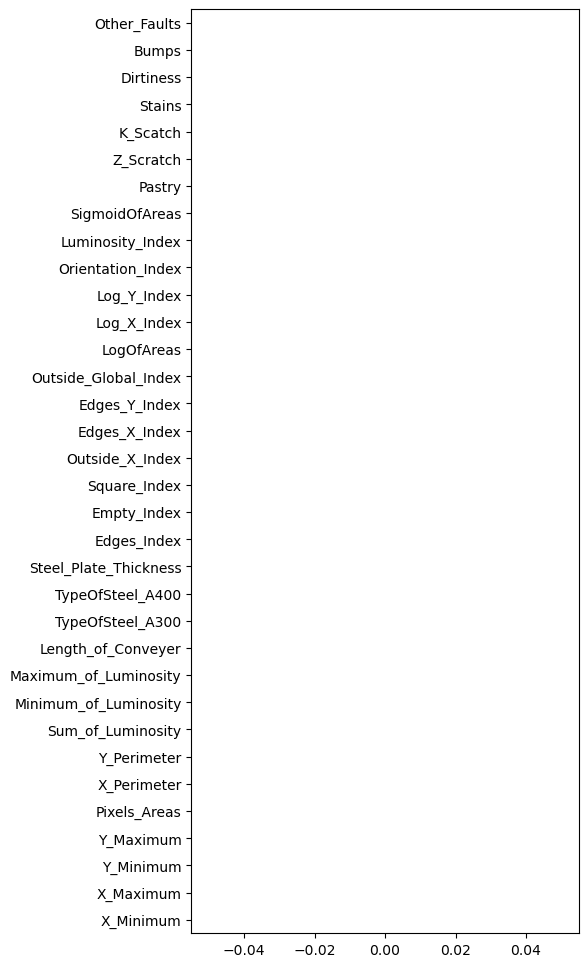

In [42]:
plt.figure(figsize=(5, 12))
train.isnull().sum().plot(kind="barh")
plt.show()

In [43]:
train.duplicated().sum()

0

## Numerical


In [44]:
numeric_only = train.select_dtypes(include=["float64", "int64"]).drop(
    TARGET_FEATURES, axis=1
)
numeric_only.describe().round(3)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,21160.000,21160.000,2.116000e+04,2.116000e+04,21160.000,21160.000,21160.000,2.116000e+04,21160.000,21160.000,...,21160.000,21160.000,21160.000,21160.000,21160.000,21160.000,21160.000,21160.000,21160.000,21160.000
mean,697.130,741.392,1.831495e+06,1.828639e+06,1703.241,97.141,65.852,1.931736e+05,84.785,128.789,...,0.031,0.614,0.830,0.590,2.475,1.315,1.391,0.101,-0.138,0.573
std,532.055,501.160,1.892922e+06,1.886266e+06,3884.801,192.510,161.188,4.489348e+05,29.121,14.673,...,0.048,0.224,0.222,0.482,0.763,0.469,0.410,0.489,0.123,0.333
min,0.000,4.000,6.712000e+03,6.724000e+03,2.000,2.000,1.000,2.500000e+02,0.000,37.000,...,0.002,0.014,0.048,0.000,0.301,0.301,0.000,-0.991,-0.999,0.119
25%,50.000,214.000,6.394900e+05,6.395070e+05,88.000,15.000,14.000,9.778000e+03,68.000,124.000,...,0.007,0.450,0.650,0.000,1.944,1.000,1.079,-0.273,-0.193,0.253
50%,754.000,772.000,1.378585e+06,1.378261e+06,169.000,25.000,24.000,1.840200e+04,90.000,127.000,...,0.010,0.636,0.962,1.000,2.228,1.146,1.322,0.111,-0.143,0.473
75%,1145.000,1161.000,2.339627e+06,2.336466e+06,659.000,67.000,62.000,6.841600e+04,105.000,135.000,...,0.019,0.786,1.000,1.000,2.819,1.431,1.716,0.526,-0.083,0.999
max,1705.000,1713.000,1.298766e+07,1.298769e+07,152655.000,10449.000,18152.000,1.159141e+07,203.000,253.000,...,0.876,1.000,1.000,1.000,5.184,3.074,4.259,0.992,0.642,1.000


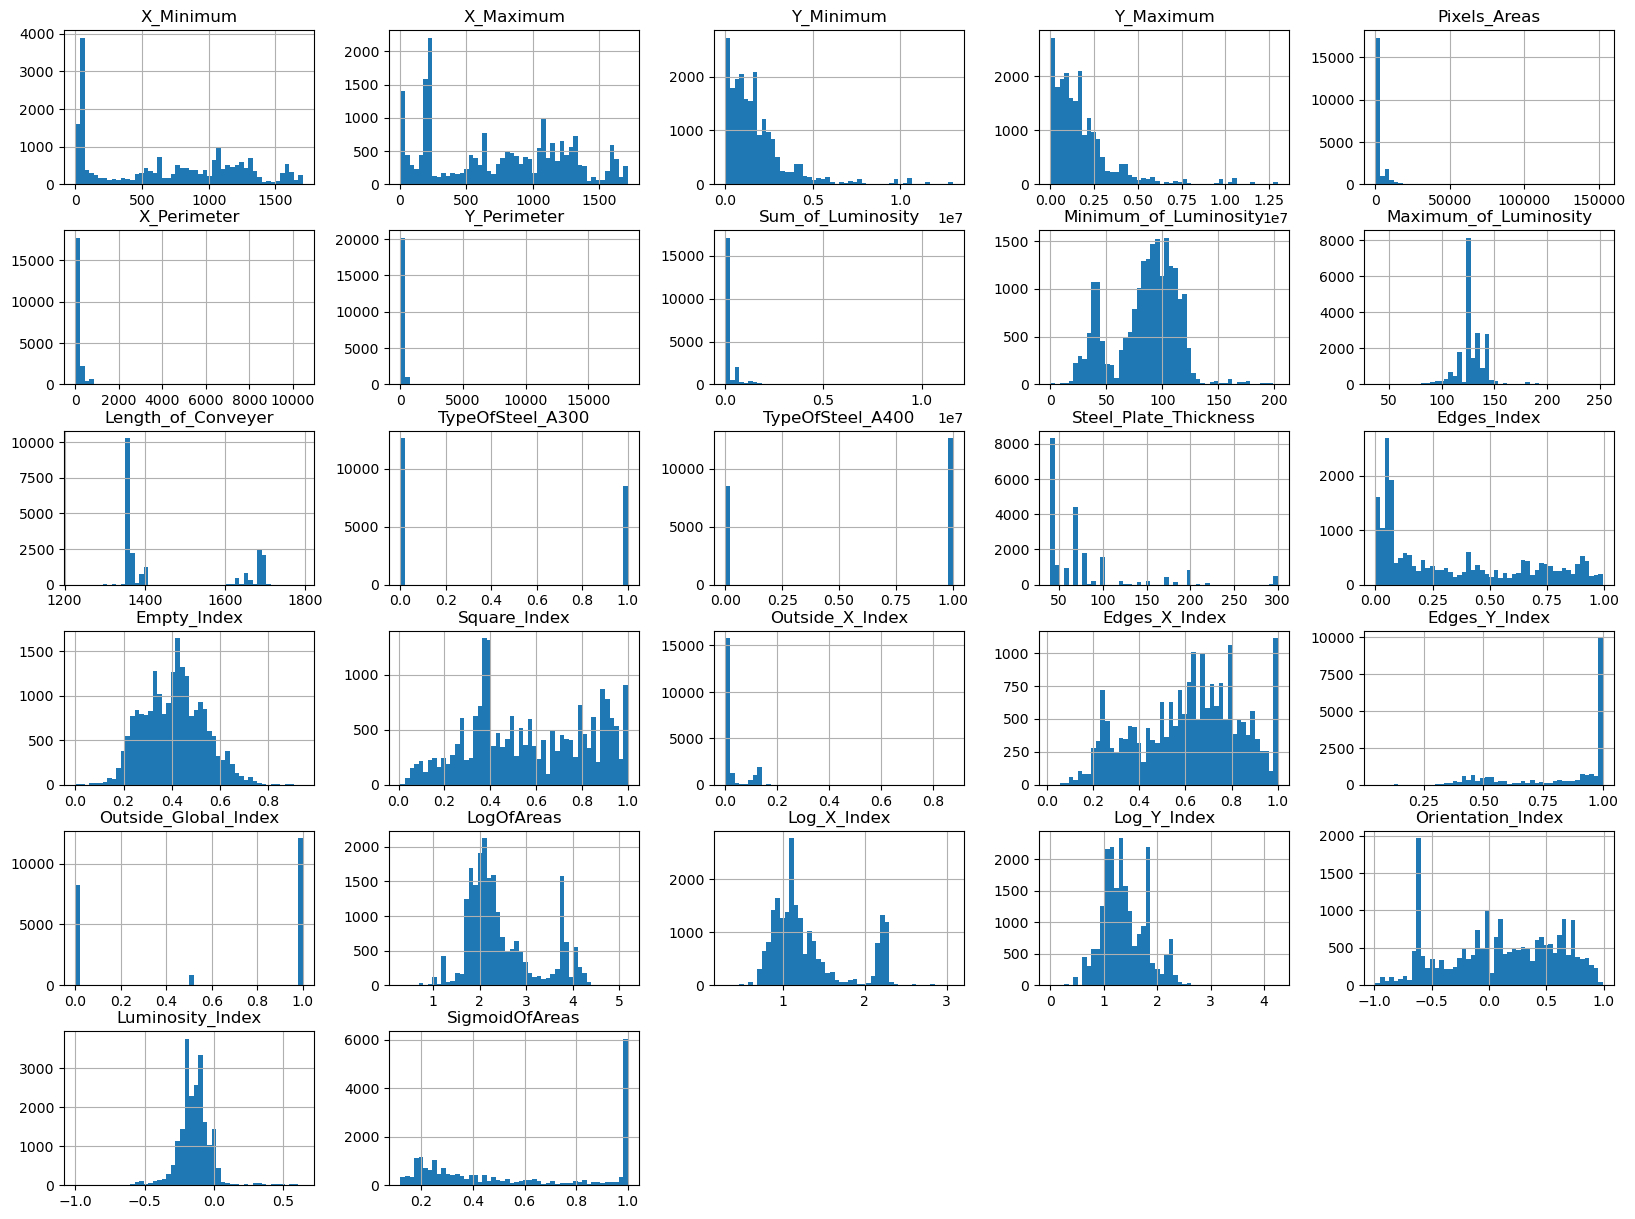

In [87]:
numeric_only.hist(bins=50, figsize=(20, 15))
plt.show()

## Categorical


In [45]:
categorical_only = train.select_dtypes(include=["object"])
categorical_only.columns

Index([], dtype='object')

## Target variable


1    20321
0      818
2       21
dtype: int64


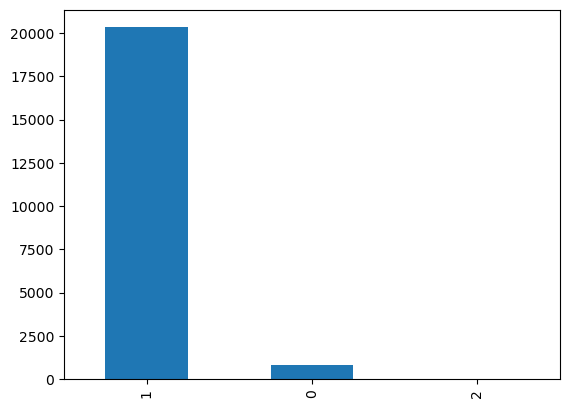

In [46]:
no_of_defects = train[TARGET_FEATURES].sum(axis=1).value_counts()
print(no_of_defects)

no_of_defects.plot(kind="bar")
plt.show()

In [47]:
train[train[TARGET_FEATURES].sum(axis=1) == 2]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
634,41,192,1682722,1682891,9927,578,343,1098162,29,141,...,0.0592,-0.1071,1.0000,0,0,1,0,0,0,1
752,39,194,2134009,2134076,10904,562,360,1130960,32,141,...,0.6522,-0.1031,0.4630,0,0,1,0,0,0,1
3572,241,360,938265,938349,2027,178,118,241083,38,108,...,-0.5833,-0.3705,1.0000,0,0,1,0,0,1,0
4416,39,729,498078,498335,13114,976,453,1438454,29,143,...,0.0442,-0.0960,1.0000,0,0,1,0,0,0,1
4530,39,222,221142,2212144,10166,634,383,1130960,31,141,...,0.0145,-0.2199,1.0000,0,0,1,0,0,0,1
4664,39,218,7430,7458,21321,758,441,2256472,22,143,...,-0.0263,-0.0573,1.0000,0,0,1,0,0,0,1
6448,41,192,92878,92896,11211,572,357,1402972,31,141,...,0.1129,-0.0948,1.0000,0,0,1,0,0,0,1
7589,41,776,844714,844903,11711,822,497,1351903,25,141,...,0.2064,-0.0971,1.0000,0,0,1,0,0,0,1
8075,41,193,1725027,1725163,10941,639,409,1270726,40,141,...,0.0642,-0.1077,1.0000,0,0,1,0,0,0,1
8538,39,215,1512277,1512467,13033,709,424,1508093,26,141,...,0.0393,-0.0966,1.0000,0,0,1,0,0,0,1


## Correlation


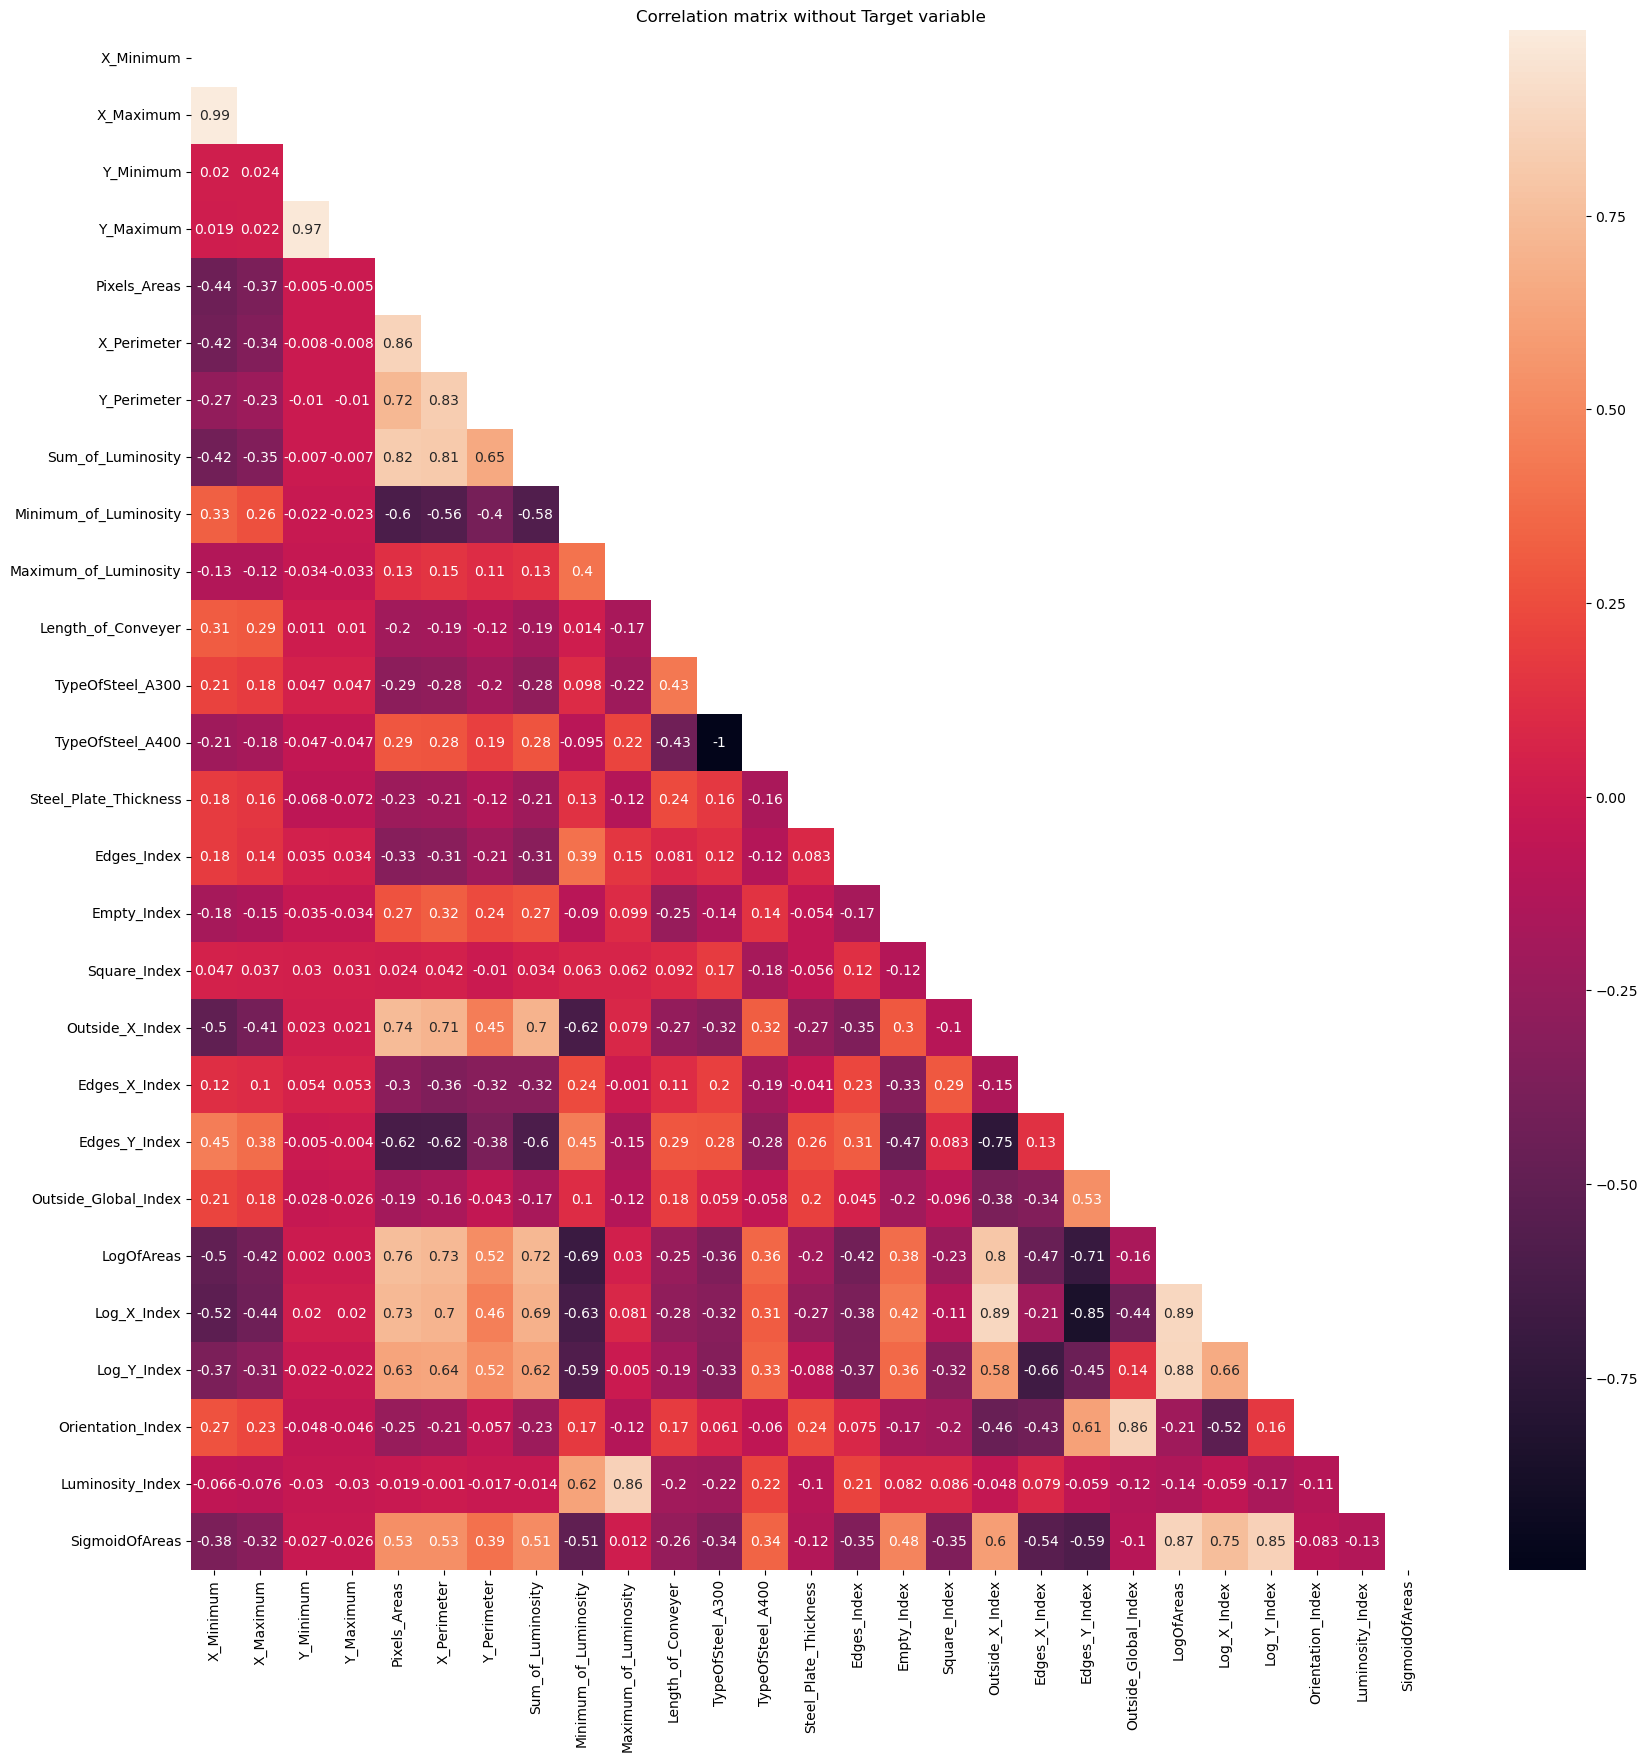

In [102]:
# Calculate the correlation matrix without target
df_without_targets = train.drop(TARGET_FEATURES, axis=1)

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(df_without_targets.corr(), dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(df_without_targets.corr().round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix without Target variable")
plt.show()

# Preprocessing


In [103]:
NEW_TARGET_CLASSES = ["No_Faults"] + TARGET_FEATURES

train["Target"] = np.argmax(train[TARGET_FEATURES].values, axis=1) + 1
train.loc[train[TARGET_FEATURES].sum(axis=1) == 0, "Target"] = 0

train.Target.value_counts()

7    7213
6    5163
3    3822
1    1624
2    1340
0     818
4     640
5     540
Name: Target, dtype: int64

In [104]:
unique_classes, counts = np.unique(train.Target, return_counts=True)

pprint(dict(zip(NEW_TARGET_CLASSES, counts)))

{'Bumps': 5163,
 'Dirtiness': 540,
 'K_Scatch': 3822,
 'No_Faults': 818,
 'Other_Faults': 7213,
 'Pastry': 1624,
 'Stains': 640,
 'Z_Scratch': 1340}


In [105]:
train.drop(TARGET_FEATURES, axis=1, inplace=True)
train.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Target'],
      dtype='object')

# Feature engineer


In [106]:
train["X_Diff"] = train["X_Maximum"] - train["X_Minimum"]
train["Y_Diff"] = train["Y_Maximum"] - train["Y_Minimum"]
train["XY_min"] = train["X_Minimum"] * train["Y_Minimum"]
train["XY_max"] = train["X_Maximum"] * train["Y_Maximum"]

train["Perimeter"] = train["X_Perimeter"] + train["Y_Perimeter"]
train["Luiminosity_Diff"] = (
    train["Maximum_of_Luminosity"] - train["Minimum_of_Luminosity"]
)

# Metrics


# Model building


## All features


In [108]:
features = train.drop("Target", axis=1)
target = train["Target"]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, stratify=target, shuffle=True, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(19044, 33)
(2116, 33)


In [112]:
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns

transformers = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough",
)

X_train_processed = transformers.fit_transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=X_train.columns)
X_train_processed_df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,X_Diff,Y_Diff,XY_min,XY_max,Perimeter,Luiminosity_Diff
0,-1.116442,-1.138410,-0.571480,-0.571957,0.412807,0.334045,0.112516,0.622842,1.071127,0.420426,...,0.682677,-1.527524,0.731861,1.281235,0.293688,0.004938,-0.607551,-0.625210,0.242946,-0.930886
1,0.065257,0.016564,-0.024375,-0.023257,-0.388991,-0.412940,-0.301092,-0.384088,-0.265291,-0.668184,...,-0.524997,-0.341460,-0.365240,-0.669105,-0.329361,0.004943,0.004249,-0.019457,-0.378433,-0.077164
2,-1.232921,-1.016729,-0.519366,-0.519598,4.736258,3.362916,2.582175,4.854599,-2.115717,0.828655,...,2.154286,-0.318143,0.493642,1.281235,1.826388,0.005322,-0.628513,-0.590968,3.144640,2.743830
3,0.626987,0.626965,-0.937456,-0.938993,-0.317952,-0.315729,-0.151234,-0.327101,0.214449,-0.872299,...,0.400724,0.987980,-0.384687,1.246981,-0.242134,0.004958,-0.620322,-0.662755,-0.251267,-0.708176
4,-1.274252,-1.415684,0.629469,0.632491,-0.342905,-0.397591,0.010613,-0.357769,-0.299559,-1.280528,...,1.025500,1.122151,-1.270308,1.123188,-0.391665,0.004940,-0.617113,-0.640478,-0.219475,-0.374111


In [28]:
rf = RandomForestClassifier(random_state=42)
gdb = GradientBoostingClassifier(random_state=42)

# Model evaluation


# Submission
